In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib widget
%config InlineBackend.figure_format = 'svg'

In [3]:
import copy
import pygmt
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

import celeri

# Plotting the global model is much much faster with tex fonts turned off
plt.rcParams["text.usetex"] = False

In [4]:
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
# celeri.plot_block_labels(segment, block, station, closure)

2025-05-13 15:39:42.215 | INFO     | celeri.celeri:read_data:441 - Reading data files
2025-05-13 15:39:42.230 | SUCCESS  | celeri.celeri:read_data:445 - Read: ../data/segment/western_north_america_segment_cascdip.csv
2025-05-13 15:39:42.231 | SUCCESS  | celeri.celeri:read_data:450 - Read: ../data/block/western_north_america_block.csv
2025-05-13 15:39:42.231 | SUCCESS  | celeri.celeri:read_data:457 - Read: ../data/mesh/western_north_america_mesh_parameters.json
2025-05-13 15:39:42.291 | SUCCESS  | celeri.celeri:read_mesh:436 - Read: ../data/mesh/cascadia.msh
2025-05-13 15:39:42.301 | SUCCESS  | celeri.celeri:read_data:525 - Read: ../data/station/western_north_america_station.csv
2025-05-13 15:39:42.302 | INFO     | celeri.celeri:read_data:540 - No mogi_file_name
2025-05-13 15:39:42.302 | INFO     | celeri.celeri:read_data:562 - No sar_file_name


In [5]:
# celeri.plot_segment_displacements(segment, station, command, segment_idx=0, strike_slip=1, dip_slip=0, tensile_slip=0, lon_min=235, lon_max=255, lat_min=30, lat_max=50, quiver_scale=1e-1)
# Plot TDE displacements from a single element
# tri_idx = 0
# vel_east, vel_north, vel_up = celeri.get_tri_displacements(station.lon.to_numpy(), station.lat.to_numpy(), meshes, command.material_lambda, command.material_mu, tri_idx=0, strike_slip=1, dip_slip=0, tensile_slip=0)
# plt.figure()
# plt.plot(meshes[0].lon1[tri_idx], meshes[0].lat1[tri_idx], ".r")
# plt.plot(meshes[0].lon2[tri_idx], meshes[0].lat2[tri_idx], ".r")
# plt.plot(meshes[0].lon3[tri_idx], meshes[0].lat3[tri_idx], ".r")
# plt.quiver(station.lon, station.lat, vel_east, vel_north, scale=1e-3)
# plt.show()

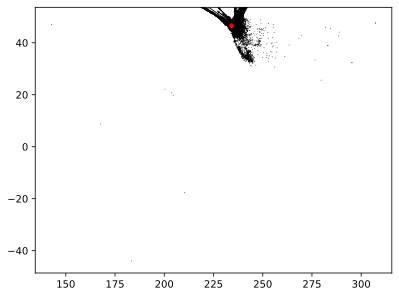

In [6]:
# Plot TDE displacements from a single element
tri_idx = 0
vel_east, vel_north, vel_up = celeri.get_tri_displacements(
    station.lon.to_numpy(),
    station.lat.to_numpy(),
    meshes,
    command.material_lambda,
    command.material_mu,
    tri_idx=0,
    strike_slip=1,
    dip_slip=0,
    tensile_slip=0,
)
plt.figure()
plt.plot(meshes[0].lon1[tri_idx], meshes[0].lat1[tri_idx], ".r")
plt.plot(meshes[0].lon2[tri_idx], meshes[0].lat2[tri_idx], ".r")
plt.plot(meshes[0].lon3[tri_idx], meshes[0].lat3[tri_idx], ".r")
plt.quiver(station.lon, station.lat, vel_east, vel_north, scale=1e-3)
plt.show()

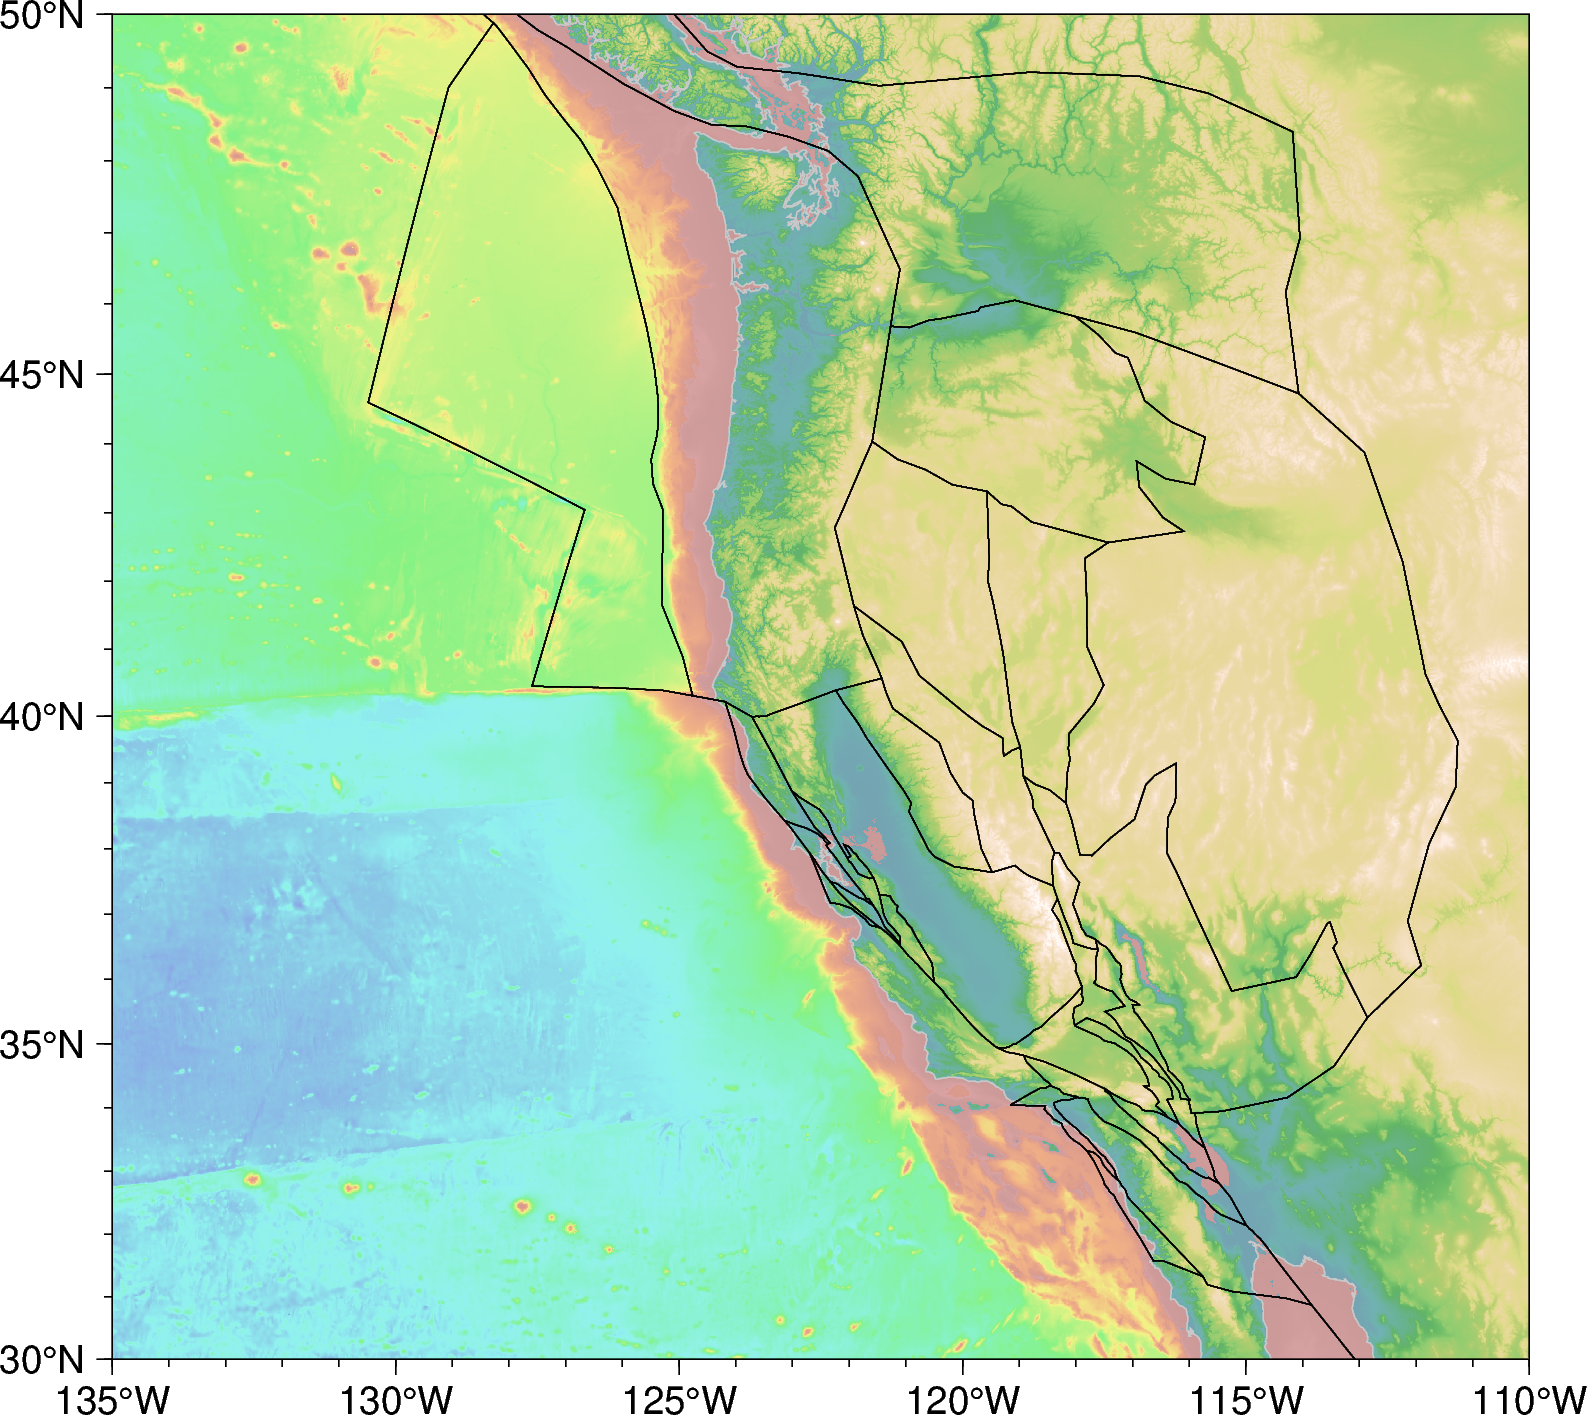

In [7]:
# Create a plot with coast, Miller projection (J) over the continental US
min_lon = -135.0
max_lon = -110.0
min_lat = 30.0
max_lat = 50.0
region = [min_lon, max_lon, min_lat, max_lat]
topo_data = "@earth_relief_30s"
# topo_data = '@earth_relief_01m'
projection = "J-65/12c"

fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
pygmt.config(MAP_FRAME_PEN="0.25p")
pygmt.config(MAP_TICK_PEN="0.25p")

pygmt.makecpt(
    cmap="topo",
    # cmap='terra',
    # series='-4000/4000/20',
    # series='-11000/4000/500',
    continuous=True,
)

fig.grdimage(
    grid=topo_data,
    region=region,
    # shading=True,
    projection=projection,
)

fig.coast(
    region=region,
    projection=projection,
    # land="lightgray",
    # water="white",
    area_thresh=4000,
    shorelines="0.25p,200/200/200",
    frame="p",
)

# Plot block boundaries
for i in range(closure.n_polygons()):
    fig.plot(
        x=closure.polygons[i].vertices[:, 0],
        y=closure.polygons[i].vertices[:, 1],
        pen="0.25p,0/0/0",
    )

# Plot GPS stations
# fig.plot(x=station.lon, y=station.lat, style="c0.05", color="yellow", pen="0.1p,black")
fig.show()

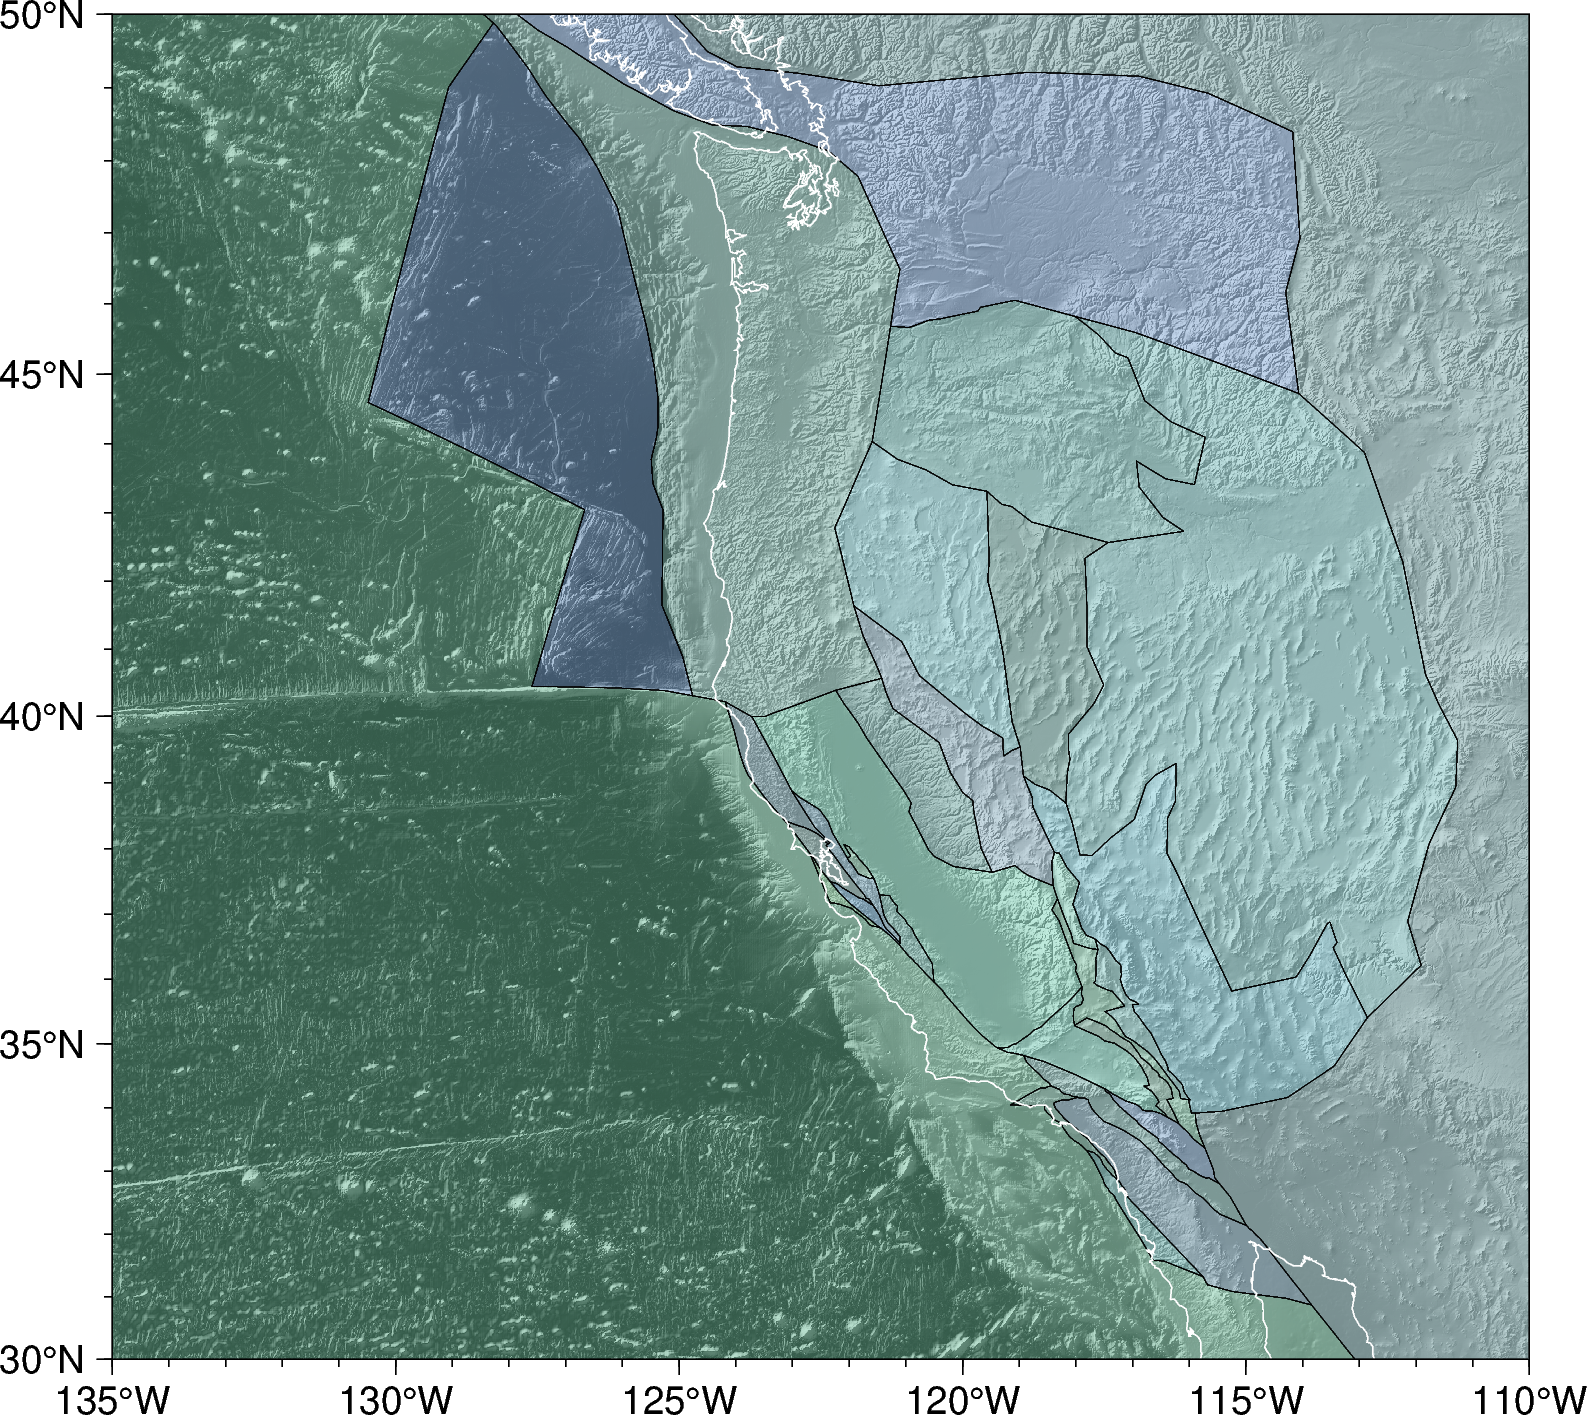

In [8]:
# Stained glass block polygons
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
pygmt.config(MAP_FRAME_PEN="0.25p")
pygmt.config(MAP_TICK_PEN="0.25p")

pygmt.makecpt(cmap="gray", series="-4000/4000/20", continuous=True)

fig.grdimage(
    grid=topo_data,
    region=region,
    shading=True,
    projection=projection,
)

# Plot blocks as transparent polygons
for i in range(closure.n_polygons()):
    red = 100 + 50 * np.random.rand(1)
    green = 150 + 100 * np.random.rand(1)
    blue = 150 + 100 * np.random.rand(1)
    color_string = str(red[0]) + "/" + str(green[0]) + "/" + str(blue[0]) + "@75"
    fig.plot(
        x=closure.polygons[i].vertices[:, 0],
        y=closure.polygons[i].vertices[:, 1],
        fill=color_string,
    )

# Plot block boundaries
for i in range(closure.n_polygons()):
    fig.plot(
        x=closure.polygons[i].vertices[:, 0],
        y=closure.polygons[i].vertices[:, 1],
        pen="0.1p,0/0/0",
    )

fig.coast(
    region=region,
    projection=projection,
    area_thresh=4000,
    shorelines="0.25p,255/255/255",
    frame="p",
)

fig.show()